<a href="https://colab.research.google.com/github/Isk5434/Reconstruction-task-4models-v3/blob/main/Reconstruction_task_4models_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

① データ読み込み


② 正常データのみ抽出

③ 再構成（次時刻予測）タスク化

④ 各モデルを学習

⑤ 予測誤差を異常スコアに変換

⑥ データ量を変えながら性能評価


#1,データの読み込み


In [23]:
from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [24]:
import pandas as pd
import os

# ベースとなるフォルダパス（マイドライブ直下にある場合）
base_path = '/content/drive/MyDrive/nasa-anomaly-detection-dataset-smap-msl'

# 1. CSVファイルの読み込み
csv_file = os.path.join(base_path, 'labeled_anomalies.csv')
df_labels = pd.read_csv(csv_file)

# 2. train と test フォルダのパスを修正
train_dir = os.path.join(base_path, 'data', 'data', 'train')
test_dir = os.path.join(base_path, 'data', 'data', 'test')

print("--- 読み込み確認 ---")
print(f"CSVラベルデータ: {df_labels.shape}")
print(f"学習データ(train)のファイル数: {len(os.listdir(train_dir))}")
print(f"テストデータ(test)のファイル数: {len(os.listdir(test_dir))}")

--- 読み込み確認 ---
CSVラベルデータ: (82, 5)
学習データ(train)のファイル数: 82
テストデータ(test)のファイル数: 82


In [25]:
os.listdir("/content/drive/MyDrive/nasa-anomaly-detection-dataset-smap-msl/data")


['data']

ステップ1：trainでモデル学習
正常な時系列とは何か？

ステップ2：testで異常スコア算出
ここ怪しくね？という数値を時系列で出す

ステップ3：CSVで評価
・異常区間に反応しているか？
・遅れていないか？
・誤検知していないか？


モデルはNGRC、RNN、時間あればLSTM

→ 評価指標はRMSE、学習時間

RMSEは低いとモデル精度良い


In [26]:
import ast

df_labels["anomaly_sequences"] = df_labels["anomaly_sequences"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else []
)


In [27]:
df_labels.iloc[0]["anomaly_sequences"]


[[2149, 2349], [4536, 4844], [3539, 3779]]

In [28]:
#長さ = 時系列の長さ
#正常 = 0
#異常区間 = 1


import numpy as np

def build_gt_labels(length, anomaly_sequences):
    y = np.zeros(length, dtype=int)
    for start, end in anomaly_sequences:
        y[start:end+1] = 1
    return y


In [29]:
# 対応する test データをロード
test_signal = np.load(
    os.path.join(test_dir, df_labels.iloc[0]["chan_id"] + ".npy")
)

y_true = build_gt_labels(
    length=len(test_signal),
    anomaly_sequences=df_labels.iloc[0]["anomaly_sequences"]
)

print(y_true.shape)
print("異常点数:", y_true.sum())


(8505,)
異常点数: 751


In [30]:
total_points = 0
total_anomaly = 0

for _, row in df_labels.iterrows():
    sig = np.load(os.path.join(test_dir, row["chan_id"] + ".npy"))
    y = build_gt_labels(len(sig), row["anomaly_sequences"])
    total_points += len(y)
    total_anomaly += y.sum()

print("全 test 点数:", total_points)
print("全 異常点数:", total_anomaly)


全 test 点数: 517764
全 異常点数: 64809


#2,学習

In [31]:
# =============================================================================
# このセルの役割:
#   プロジェクト全体で使うライブラリを一括 import する。
#   numpy/pandas/matplotlib に加え、sklearn (Ridge回帰, AUC計算, スケーリング) と
#   PyTorch (RNN/LSTM 用) を読み込む。
#   Round 3 で precision_recall_curve, average_precision_score を追加。
# =============================================================================
import os
import random
import math
import glob
import ast
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

# ML libs
import sklearn
from sklearn.linear_model import Ridge
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [32]:
# =============================================================================
# このセルの役割:
#   実験全体のパス設定・乱数シード・ハイパーパラメータを一箇所に集約。
#   Colab で Google Drive 上の NASA SMAP/MSL データセットを参照するパスを定義し、
#   再現性のため numpy/random/torch のシードを固定する。
#   Round 3 で追加: ウィンドウ数ベースの学習量リスト sizes_windows、
#   ESN メモリ上限 esn_max_windows、各モデルのハイパーパラメータ辞書。
# =============================================================================
base_path = '/content/drive/MyDrive/nasa-anomaly-detection-dataset-smap-msl'
train_dir = os.path.join(base_path, 'data', 'data', 'train')
test_dir  = os.path.join(base_path, 'data', 'data', 'test')
csv_file = os.path.join(base_path, 'labeled_anomalies.csv')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
random_seed = 42
np.random.seed(random_seed)
random.seed(random_seed)
torch.manual_seed(random_seed)

# --- Round 3 新パラメータ ---
window_size = 50                           # スライディングウィンドウ幅
sizes_windows = [100, 500, 1000, 5000]     # 学習に使うウィンドウ数のリスト
esn_max_windows = 2000                     # ESN の学習ウィンドウ上限 (二重forのため)
esn_params = {'n_reservoir': 200, 'spectral_radius': 0.9,
              'sparsity': 0.05, 'leak_rate': 1.0, 'alpha': 1.0}
ngrc_params = {'delay': 10, 'transform_size': 300, 'alpha': 1.0}
rnn_params = {'hidden_size': 64, 'epochs': 10, 'lr': 1e-3, 'batch_size': 64}

In [33]:
# -----------------------
# ユーティリティ: ファイル -> numpy シーケンス読み込み
# 想定: 各データファイルは CSV で、先頭行にカラム名（sensor1,..）がある
# -----------------------
def load_series_from_file(path):
    if path.endswith('.npy'):
        return np.load(path).astype(np.float32)
    elif path.endswith('.csv') or path.endswith('.txt'):
        try:
            df = pd.read_csv(path, encoding='utf-8')
        except UnicodeDecodeError:
            df = pd.read_csv(path, encoding='shift_jis')
        numeric = df.select_dtypes(include=[np.number])
        return numeric.values.astype(np.float32)  # shape: (T, D)
    else:
        raise ValueError(f"Unsupported file type for: {path}")

def list_files_in_dir(d):
    exts = ('*.csv', '*.txt', '*.npy')
    files = []
    for e in exts:
        files += glob.glob(os.path.join(d, e))
    files = sorted(files)
    return files

In [34]:
def make_windows(series, window_size=50):
    """時系列を (入力ウィンドウ, 次時刻ターゲット) のペアに変換する。

    Parameters
    ----------
    series : np.ndarray, shape (T, D)
    window_size : int

    Returns
    -------
    X : np.ndarray, shape (N, window_size, D)
    Y : np.ndarray, shape (N, D)
    """
    T, D = series.shape
    X, Y = [], []
    for t in range(window_size, T):
        X.append(series[t-window_size:t, :])
        Y.append(series[t, :])
    if len(X) == 0:
        return np.empty((0, window_size, D), dtype=np.float32), \
               np.empty((0, D), dtype=np.float32)
    return np.stack(X), np.stack(Y)


# センサータイプ別前処理パイプライン
# SMAP (D=25) と MSL (D=55) を分離して扱い、同一センサー内で StandardScaler のみ適用する。
# Round 1 ではゼロパディング+PCA で統一していたが、Round 3 では分離方式に変更。

In [35]:
# =============================================================================
# このセルの役割:
#   NASA SMAP/MSL データセットのファイルを SMAP と MSL に分類し、
#   センサータイプ別に StandardScaler を fit する前処理関数群を定義する。
#   同一センサー内では次元が揃う (SMAP=25, MSL=55) ので PCA は不要。
#
#   関数一覧:
#     split_files_by_sensor()       - labeled_anomalies.csv を使い train/test を振り分け
#     fit_scaler_for_sensor()       - 同一センサーの全 train で StandardScaler を fit
#     transform_series_for_sensor() - fit 済み scaler で時系列を変換
# =============================================================================

def split_files_by_sensor(train_files, test_files, csv_path):
    """train/test ファイルを SMAP / MSL に分割する。

    labeled_anomalies.csv の spacecraft 列 ('SMAP' or 'MSL') を参照し、
    chan_id -> spacecraft のマッピングを作る。
    CSV に載っていない train ファイルは次元数 (25→SMAP, 55→MSL) で判定。

    Returns
    -------
    dict : {'SMAP': {'train': [...], 'test': [...]},
            'MSL':  {'train': [...], 'test': [...]}}
    """
    df = pd.read_csv(csv_path)
    chan_to_sc = {}
    for _, row in df.iterrows():
        chan_to_sc[str(row['chan_id'])] = str(row['spacecraft']).upper()

    result = {
        'SMAP': {'train': [], 'test': []},
        'MSL':  {'train': [], 'test': []}
    }

    def classify(path):
        base = os.path.splitext(os.path.basename(path))[0]
        if base in chan_to_sc:
            return chan_to_sc[base]
        # CSV に無い場合は .npy の次元数で判定
        try:
            seq = np.load(path) if path.endswith('.npy') else None
            if seq is not None:
                D = seq.shape[1] if seq.ndim == 2 else 1
                return 'SMAP' if D <= 25 else 'MSL'
        except Exception:
            pass
        return 'SMAP'

    for f in train_files:
        sc = classify(f)
        result[sc]['train'].append(f)
    for f in test_files:
        sc = classify(f)
        result[sc]['test'].append(f)

    for sc in ['SMAP', 'MSL']:
        print(f"[split_files_by_sensor] {sc}: "
              f"train={len(result[sc]['train'])}, test={len(result[sc]['test'])}")
    return result


def fit_scaler_for_sensor(train_files, sample_max_per_file=5000):
    """同一センサータイプの全 train ファイルで StandardScaler を fit する。

    同一センサー内では全ファイルの特徴次元 D が同一なので
    ゼロパディングも PCA も不要。

    Returns
    -------
    scaler : fitted StandardScaler
    D : int  (特徴次元数)
    """
    all_rows = []
    D = None
    for f in train_files:
        seq = load_series_from_file(f)
        T_i, D_i = seq.shape
        if D is None:
            D = D_i
        else:
            assert D == D_i, f"次元不一致: 期待 D={D}, got {D_i} in {f}"
        if T_i > sample_max_per_file:
            idx = np.random.choice(T_i, sample_max_per_file, replace=False)
            seq = seq[idx]
        all_rows.append(seq)

    all_data = np.concatenate(all_rows, axis=0)
    print(f"[fit_scaler_for_sensor] データ形状: {all_data.shape}, D={D}")

    scaler = StandardScaler()
    scaler.fit(all_data)
    scaler.scale_ = np.where(scaler.scale_ == 0, 1.0, scaler.scale_)
    return scaler, D


def transform_series_for_sensor(seq, scaler):
    """fit 済み StandardScaler で時系列を変換する (PCA なし)。

    Returns
    -------
    np.ndarray, shape (T, D), dtype float32
    """
    return scaler.transform(seq).astype(np.float32)

In [36]:
# =============================================================================
# このセルの役割:
#   ポイントワイズ (タイムステップ単位) の評価に必要な正解ラベルを構築する。
#   Cell 8 の build_gt_labels() を内部で利用し、chan_id ごとに
#   (1) 0/1 のタイムステップラベル (ROC-AUC/PR-AUC 用)
#   (2) 異常区間リスト [[start, end], ...] (Detection Delay 用)
#   を返す関数を定義する。
# =============================================================================

def build_pointwise_labels(chan_id, df_labels, signal_length):
    """chan_id に対応するタイムステップレベルの GT ラベル (0/1) を構築する。

    Parameters
    ----------
    chan_id : str      例: 'P-1', 'M-6'
    df_labels : pd.DataFrame  (anomaly_sequences 列はリスト化済み)
    signal_length : int

    Returns
    -------
    np.ndarray, shape (signal_length,), dtype int
    """
    row = df_labels[df_labels['chan_id'] == chan_id]
    if len(row) == 0:
        return np.zeros(signal_length, dtype=int)
    anomaly_seqs = row.iloc[0]['anomaly_sequences']
    if not isinstance(anomaly_seqs, list):
        anomaly_seqs = ast.literal_eval(anomaly_seqs) if isinstance(anomaly_seqs, str) else []
    return build_gt_labels(signal_length, anomaly_seqs)


def get_anomaly_intervals(chan_id, df_labels):
    """chan_id の異常区間リスト [[start, end], ...] を返す。

    Detection Delay の計算で使用: 各区間について
    「閾値超過までの遅延ステップ数」を求める。

    Returns
    -------
    list of [int, int]
    """
    row = df_labels[df_labels['chan_id'] == chan_id]
    if len(row) == 0:
        return []
    anomaly_seqs = row.iloc[0]['anomaly_sequences']
    if not isinstance(anomaly_seqs, list):
        anomaly_seqs = ast.literal_eval(anomaly_seqs) if isinstance(anomaly_seqs, str) else []
    return anomaly_seqs

# NGRC

In [37]:
# =============================================================================
# このセルの役割:
#   NGRC (Next Generation Reservoir Computing) モデルの定義。
#   アルゴリズム:
#     1. 遅延埋め込み: ウィンドウ末尾 delay ステップをフラット化 → (N, delay*D)
#     2. 固定ランダム射影: W_in (transform_size, delay*D) で tanh 非線形変換
#     3. Ridge 回帰: 変換後特徴 → ターゲット Y を線形フィット
#   W_in は fit 時にデータ次元に基づき遅延初期化 (lazy init) する。
#   Round 3 追加: get_ridge_weights() メソッド (チャネル重要度分析用)。
# =============================================================================
class NGRC:
    def __init__(self, delay=10, transform_size=200, alpha=1.0):
        self.delay = delay
        self.transform_size = transform_size
        self.alpha = alpha
        self.W_in = None  # lazy init
        self.b = np.zeros((transform_size,))
        self.ridge = None
        self.scaler_in = StandardScaler()
        self.scaler_out = StandardScaler()
        self._rng = np.random.RandomState(random_seed)

    def _init_W_in(self, input_dim):
        """W_in を (transform_size, input_dim) で初期化。"""
        self.W_in = self._rng.randn(self.transform_size, input_dim) * 0.1
        print(f"[NGRC] W_in 初期化: shape={self.W_in.shape}")

    def _featurize(self, X):
        """X: (N, W, D) -> 特徴量 (N, transform_size)"""
        N, W, D = X.shape
        delay = min(self.delay, W)
        x_delay = X[:, -delay:, :].reshape(N, delay * D)  # (N, delay*D)
        if self.W_in is None:
            self._init_W_in(x_delay.shape[1])
        assert self.W_in.shape[1] == x_delay.shape[1], \
            f"NGRC W_in 次元不一致: 期待={self.W_in.shape[1]}, 入力={x_delay.shape[1]}"
        z = np.tanh(self.W_in.dot(x_delay.T) + self.b[:, None])
        return z.T  # (N, transform_size)

    def fit(self, X, Y):
        """学習: X (N, W, D), Y (N, D)"""
        self.W_in = None
        self._rng = np.random.RandomState(random_seed)
        Z = self._featurize(X)
        self.scaler_in.fit(Z)
        Zs = self.scaler_in.transform(Z)
        self.scaler_out.fit(Y)
        Ys = self.scaler_out.transform(Y)
        self.ridge = Ridge(alpha=self.alpha, fit_intercept=True)
        self.ridge.fit(Zs, Ys)

    def predict(self, X):
        """予測: X (N, W, D) -> Y_pred (N, D)"""
        Z = self._featurize(X)
        Zs = self.scaler_in.transform(Z)
        Ys = self.ridge.predict(Zs)
        return self.scaler_out.inverse_transform(Ys)

    def get_ridge_weights(self):
        """Ridge 回帰の係数行列を返す。shape: (D_out, transform_size)"""
        if self.ridge is None:
            return None
        return self.ridge.coef_

# ESN

In [38]:
# =============================================================================
# このセルの役割:
#   ESN (Echo State Network) モデルの定義。
#   アルゴリズム:
#     1. スパースランダム結合のリカレントリザーバーを構築
#     2. 入力系列を 1 ステップずつリザーバーに流し、最終状態を取得
#     3. Ridge 回帰で最終リザーバー状態 → ターゲット Y を学習
#   注意: _collect_states() が二重 for ループ (N * W) のため遅い。
#         max_windows でサブサンプルしてメモリ・時間を制限する。
#   Round 3 追加: fit() に max_windows 引数、get_ridge_weights() メソッド。
# =============================================================================
class ESN:
    def __init__(self, n_inputs, n_reservoir=500, spectral_radius=0.9,
                 sparsity=0.1, leak_rate=1.0, alpha=1.0):
        self.n_inputs = n_inputs
        self.n_reservoir = n_reservoir
        self.spectral_radius = spectral_radius
        self.sparsity = sparsity
        self.leak_rate = leak_rate
        self.alpha = alpha
        rng = np.random.RandomState(random_seed)
        W = rng.rand(n_reservoir, n_reservoir) - 0.5
        mask = rng.rand(n_reservoir, n_reservoir) < sparsity
        W *= mask
        eigs = np.linalg.eigvals(W)
        radius = max(abs(eigs)) if len(eigs) > 0 else 1.0
        if radius == 0:
            radius = 1.0
        W *= (spectral_radius / radius)
        self.W = W
        self.W_in = (rng.rand(n_reservoir, n_inputs) - 0.5) * 1.0
        self.b = np.zeros((n_reservoir,))
        self.readout = None
        self.scaler_in = StandardScaler()
        self.scaler_out = StandardScaler()

    def _collect_states(self, X):
        """X: (N, W, D) -> リザーバー最終状態 (N, n_reservoir)"""
        N, W, D = X.shape
        assert D == self.n_inputs, \
            f"ESN 入力次元不一致: n_inputs={self.n_inputs}, D={D}"
        states = []
        for i in range(N):
            u_seq = X[i]
            x = np.zeros(self.n_reservoir)
            for t in range(u_seq.shape[0]):
                u = u_seq[t]
                pre = self.W.dot(x) + self.W_in.dot(u) + self.b
                x = (1.0 - self.leak_rate) * x + self.leak_rate * np.tanh(pre)
            states.append(x.copy())
        return np.stack(states)

    def fit(self, X, Y, max_windows=None):
        """学習。max_windows 超過時はランダムサブサンプルする。"""
        if max_windows is not None and X.shape[0] > max_windows:
            print(f"[ESN] 学習データを {X.shape[0]} -> {max_windows} にサブサンプル")
            idx = np.random.choice(X.shape[0], max_windows, replace=False)
            X, Y = X[idx], Y[idx]
        S = self._collect_states(X)
        self.scaler_in.fit(S)
        Ss = self.scaler_in.transform(S)
        self.scaler_out.fit(Y)
        Ys = self.scaler_out.transform(Y)
        self.readout = Ridge(alpha=self.alpha, fit_intercept=True)
        self.readout.fit(Ss, Ys)

    def predict(self, X):
        """予測: X (N, W, D) -> Y_pred (N, D)"""
        S = self._collect_states(X)
        Ss = self.scaler_in.transform(S)
        Yp = self.readout.predict(Ss)
        return self.scaler_out.inverse_transform(Yp)

    def get_ridge_weights(self):
        """Ridge 回帰の係数行列を返す。shape: (D_out, n_reservoir)"""
        if self.readout is None:
            return None
        return self.readout.coef_

# RNN/LSTM

In [39]:
# =============================================================================
# このセルの役割:
#   PyTorch ベースの RNN / LSTM モデルの定義。
#   - SequenceDataset: numpy → PyTorch DataLoader 用ラッパー
#   - SimpleRNN / SimpleLSTM: 単層の RNN/LSTM → Linear で次ステップ予測
#   - train_torch_model(): Adam + MSELoss で学習ループ
#   - predict_torch_model(): GPU/CPU を自動判定して推論
#   チャネル重要度は外部の permutation importance 関数で計算する。
# =============================================================================
class SequenceDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X.astype(np.float32)
        self.Y = Y.astype(np.float32)
    def __len__(self):
        return self.X.shape[0]
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), torch.from_numpy(self.Y[idx])

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1):
        super().__init__()
        self.input_size = input_size
        self.rnn = nn.RNN(input_size, hidden_size, num_layers=num_layers,
                          batch_first=True, nonlinearity='tanh')
        self.out = nn.Linear(hidden_size, input_size)
    def forward(self, x):
        assert x.shape[-1] == self.input_size, \
            f"RNN 入力次元不一致: input_size={self.input_size}, got={x.shape[-1]}"
        h, _ = self.rnn(x)
        last = h[:, -1, :]
        return self.out(last)

class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1):
        super().__init__()
        self.input_size = input_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,
                            batch_first=True)
        self.out = nn.Linear(hidden_size, input_size)
    def forward(self, x):
        assert x.shape[-1] == self.input_size, \
            f"LSTM 入力次元不一致: input_size={self.input_size}, got={x.shape[-1]}"
        h, _ = self.lstm(x)
        last = h[:, -1, :]
        return self.out(last)

def train_torch_model(model, train_loader, val_loader=None, epochs=10, lr=1e-3):
    """PyTorch モデルの学習ループ (Adam + MSELoss)。"""
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for ep in range(epochs):
        model.train()
        total = 0.0
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            opt.zero_grad()
            loss.backward()
            opt.step()
            total += loss.item() * xb.size(0)
    return model

def predict_torch_model(model, X):
    """PyTorch モデルで推論。X: (N, W, D) -> Y_pred: (N, D)"""
    model.to(device)
    model.eval()
    with torch.no_grad():
        xb = torch.from_numpy(X.astype(np.float32)).to(device)
        pred = model(xb).cpu().numpy()
    return pred

# チャネル重要度分析
# NGRC/ESN: Ridge 回帰の重み行列を入力チャネル空間に逆投影して寄与度を算出
# RNN/LSTM: Permutation Importance (チャネルをシャッフルし MSE 変化量を測定)

In [40]:
# =============================================================================
# このセルの役割:
#   各モデルの「どのセンサーチャネルが異常検知に重要か」を定量化する関数群。
#
#   NGRC 用: Ridge.coef_ × W_in を掛け合わせ、delay*D → D にリシェイプ合算。
#            これにより「どのチャネルの遅延値が予測に寄与しているか」が分かる。
#   ESN 用 : Ridge.coef_ × ESN.W_in を掛け合わせて同様に D 次元に集約。
#   RNN/LSTM 用: 各チャネルをランダムシャッフルして MSE の増加量を測定する
#                Permutation Importance 方式。モデル非依存で汎用的。
# =============================================================================

def channel_importance_ridge_ngrc(ngrc_model, D, delay):
    """NGRC の Ridge 重みを入力チャネル空間に逆投影する。

    経路: 入力 x_delay (delay*D) → W_in → tanh → z → Ridge → Y_pred
    重要度 = |Ridge.coef_ @ W_in| を (delay, D) にリシェイプし delay 方向に合算。

    Returns: importance shape (D,), 正規化済み (合計=1)
    """
    coef = ngrc_model.get_ridge_weights()
    W_in = ngrc_model.W_in
    if coef is None or W_in is None:
        return np.zeros(D)
    contribution = np.abs(coef @ W_in)        # (D_out, delay*D)
    contribution = contribution.sum(axis=0)    # (delay*D,)
    actual_delay = W_in.shape[1] // D
    contribution = contribution.reshape(actual_delay, D).sum(axis=0)
    total = contribution.sum()
    if total > 0:
        contribution /= total
    return contribution


def channel_importance_ridge_esn(esn_model, D):
    """ESN の Ridge 重みを入力チャネル空間に逆投影する。

    経路: 入力 u (D) → W_in → リザーバー状態 → Ridge → Y_pred
    重要度 = |Ridge.coef_ @ ESN.W_in| の列合算。

    Returns: importance shape (D,), 正規化済み
    """
    coef = esn_model.get_ridge_weights()
    W_in = esn_model.W_in
    if coef is None or W_in is None:
        return np.zeros(D)
    contribution = np.abs(coef @ W_in)        # (D_out, D)
    contribution = contribution.sum(axis=0)    # (D,)
    total = contribution.sum()
    if total > 0:
        contribution /= total
    return contribution


def channel_importance_permutation(model_predict_fn, X_test, Y_test, n_repeats=5):
    """Permutation Importance でチャネル重要度を測定する。

    各チャネル d について:
      1. d 列をサンプル間でシャッフル
      2. MSE を再計算
      3. ベースライン MSE との差 = そのチャネルの重要度
    n_repeats 回繰り返して平均をとる。

    Returns: importance shape (D,), 正規化済み
    """
    N, W, D = X_test.shape
    Y_pred = model_predict_fn(X_test)
    base_mse = np.mean((Y_test - Y_pred) ** 2)

    importance = np.zeros(D)
    for d in range(D):
        mse_increase = 0.0
        for _ in range(n_repeats):
            X_perm = X_test.copy()
            perm_idx = np.random.permutation(N)
            X_perm[:, :, d] = X_test[perm_idx, :, d]
            Y_perm_pred = model_predict_fn(X_perm)
            perm_mse = np.mean((Y_test - Y_perm_pred) ** 2)
            mse_increase += (perm_mse - base_mse)
        importance[d] = mse_increase / n_repeats

    importance = np.clip(importance, 0, None)
    total = importance.sum()
    if total > 0:
        importance /= total
    return importance

# ポイントワイズ評価関数
# テストファイルごとにタイムステップ単位で異常スコアを算出し、
# ROC-AUC, PR-AUC, Detection Delay を計算する

In [41]:
# =============================================================================
# このセルの役割:
#   ポイントワイズ (タイムステップ単位) の異常検知評価を行う関数群。
#   旧版ではファイルレベル AUC (全テストファイルに異常ありで意味がなかった) を
#   使っていたが、Round 3 では各タイムステップの MSE を異常スコアとして
#   ROC-AUC / PR-AUC / Detection Delay を正しく算出する。
#
#   関数一覧:
#     compute_pointwise_scores()      - 1ファイルの MSE スコア列 (T,) を算出
#     compute_normal_threshold()      - 正常データの 95 パーセンタイルで閾値設定
#     compute_detection_delay()       - 異常区間ごとの検出遅延を計算
#     evaluate_pointwise_single_file()- 1テストファイルの完全評価
#     evaluate_on_test_pointwise()    - 全テストファイルの集約評価
# =============================================================================

def compute_pointwise_scores(series_transformed, model_predict_fn, window_size=50):
    """1ファイル分の変換済み時系列からタイムステップごとの MSE スコアを算出。

    ウィンドウ i (= series[i:i+window_size]) は timestep (window_size + i) を予測。
    先頭 window_size 個はスコアなし (0.0)。

    Returns: scores shape (T,)
    """
    T, D = series_transformed.shape
    scores = np.zeros(T, dtype=np.float32)
    X, Y = make_windows(series_transformed, window_size=window_size)
    if X.shape[0] == 0:
        return scores
    Y_pred = model_predict_fn(X)
    mse_per_window = np.mean((Y - Y_pred) ** 2, axis=1)
    for i, mse_val in enumerate(mse_per_window):
        t = window_size + i
        if t < T:
            scores[t] = mse_val
    return scores


def compute_normal_threshold(train_files, scaler, model_predict_fn,
                              window_size=50, percentile=95, max_files=20):
    """正常 train データの MSE スコア分布から閾値を算出する。

    正常データでもゼロでないスコア (= window_size 以降) を集め、
    その percentile を閾値とする。

    Returns: threshold (float)
    """
    all_scores = []
    files_to_use = train_files[:max_files]
    for f in files_to_use:
        seq = load_series_from_file(f)
        seq_t = transform_series_for_sensor(seq, scaler)
        sc = compute_pointwise_scores(seq_t, model_predict_fn, window_size)
        nonzero = sc[sc > 0]
        if len(nonzero) > 0:
            all_scores.append(nonzero)
    if len(all_scores) == 0:
        return 1.0
    all_scores = np.concatenate(all_scores)
    threshold = np.percentile(all_scores, percentile)
    print(f"[threshold] {percentile}th percentile = {threshold:.6f}")
    return threshold


def compute_detection_delay(scores, y_true, threshold, anomaly_intervals):
    """各異常区間で閾値を超えた最初のタイムステップまでの遅延を計算。

    Returns: delays (list of int), 検出失敗は -1
    """
    delays = []
    for start, end in anomaly_intervals:
        found = False
        for t in range(start, min(end + 1, len(scores))):
            if scores[t] > threshold:
                delays.append(t - start)
                found = True
                break
        if not found:
            delays.append(-1)
    return delays


def evaluate_pointwise_single_file(chan_id, series_path, model_predict_fn,
                                    scaler, df_labels, window_size=50,
                                    threshold=None):
    """1テストファイルのポイントワイズ評価。

    Returns: dict {chan_id, roc_auc, pr_auc, detection_delays, n_anomaly_points}
    """
    seq = load_series_from_file(series_path)
    T = seq.shape[0]
    seq_t = transform_series_for_sensor(seq, scaler)
    scores = compute_pointwise_scores(seq_t, model_predict_fn, window_size)
    y_true = build_pointwise_labels(chan_id, df_labels, T)
    anomaly_intervals = get_anomaly_intervals(chan_id, df_labels)

    result = {
        'chan_id': chan_id,
        'n_anomaly_points': int(y_true.sum()),
        'roc_auc': float('nan'),
        'pr_auc': float('nan'),
        'detection_delays': []
    }

    if len(set(y_true)) > 1:
        try:
            result['roc_auc'] = roc_auc_score(y_true, scores)
        except Exception:
            pass
        try:
            result['pr_auc'] = average_precision_score(y_true, scores)
        except Exception:
            pass

    if threshold is not None and len(anomaly_intervals) > 0:
        result['detection_delays'] = compute_detection_delay(
            scores, y_true, threshold, anomaly_intervals)
    return result


def evaluate_on_test_pointwise(test_files, model_predict_fn, scaler,
                                df_labels, window_size=50, threshold=None):
    """全テストファイルのポイントワイズ評価を集約する。

    Returns: dict {mean_roc_auc, mean_pr_auc, mean_detection_delay, per_channel}
    """
    per_channel = {}
    roc_aucs, pr_aucs, all_delays = [], [], []

    for f in test_files:
        chan_id = os.path.splitext(os.path.basename(f))[0]
        r = evaluate_pointwise_single_file(
            chan_id, f, model_predict_fn, scaler, df_labels,
            window_size, threshold)
        per_channel[chan_id] = r
        if not np.isnan(r['roc_auc']):
            roc_aucs.append(r['roc_auc'])
        if not np.isnan(r['pr_auc']):
            pr_aucs.append(r['pr_auc'])
        for d in r['detection_delays']:
            if d >= 0:
                all_delays.append(d)

    return {
        'mean_roc_auc': np.mean(roc_aucs) if roc_aucs else float('nan'),
        'mean_pr_auc': np.mean(pr_aucs) if pr_aucs else float('nan'),
        'mean_detection_delay': np.mean(all_delays) if all_delays else float('nan'),
        'per_channel': per_channel
    }

# 実験パイプライン
# ウィンドウ数ベースで学習量を変化させ、SMAP / MSL 別に 4 モデルを比較する

In [42]:
# =============================================================================
# このセルの役割:
#   ウィンドウ数ベースの実験メインループを定義する。
#   1. fit_scaler_for_sensor() で同一センサーの train 全体からスケーラー fit
#   2. collect_all_train_windows() で全学習ウィンドウを収集
#   3. sizes_windows の各値 n_win について:
#      a. sample_training_windows() で n_win 個をランダムサンプル
#      b. 4 モデル (NGRC/ESN/RNN/LSTM) を学習
#      c. evaluate_on_test_pointwise() でポイントワイズ評価
#      d. channel_importance_*() でチャネル重要度を算出
#   4. 結果を DataFrame に集約して返す
# =============================================================================

def collect_all_train_windows(train_files, scaler, window_size=50):
    """全 train ファイルからスライディングウィンドウを収集・結合する。

    Returns: X_all (N_total, W, D), Y_all (N_total, D)
    """
    X_list, Y_list = [], []
    for f in train_files:
        seq = load_series_from_file(f)
        seq_t = transform_series_for_sensor(seq, scaler)
        X, Y = make_windows(seq_t, window_size=window_size)
        if X.shape[0] > 0:
            X_list.append(X)
            Y_list.append(Y)
    if len(X_list) == 0:
        return np.empty((0, window_size, 1)), np.empty((0, 1))
    return np.concatenate(X_list, axis=0), np.concatenate(Y_list, axis=0)


def sample_training_windows(X_all, Y_all, n_windows):
    """全ウィンドウから n_windows 個をランダムサンプリングする。"""
    N = X_all.shape[0]
    if n_windows >= N:
        print(f"  要求={n_windows} >= 全量={N}, 全データ使用")
        return X_all, Y_all
    idx = np.random.choice(N, n_windows, replace=False)
    return X_all[idx], Y_all[idx]


def run_experiment_by_windows(sensor_type, train_files, test_files,
                               sizes_windows, df_labels, window_size=50,
                               esn_params=None, ngrc_params=None,
                               rnn_params=None, esn_max_windows=2000):
    """ウィンドウ数ベース実験のメインループ。

    Returns
    -------
    results_df : pd.DataFrame (sensor_type, model, n_windows, roc_auc, pr_auc, mean_detection_delay)
    ch_imp : dict {model_name: {n_windows: importance_array}}
    """
    print(f"\n--- {sensor_type}: スケーラー fitting ---")
    scaler, D = fit_scaler_for_sensor(train_files)

    print(f"\n--- {sensor_type}: 全学習ウィンドウ収集 ---")
    X_all, Y_all = collect_all_train_windows(train_files, scaler, window_size)
    print(f"  全ウィンドウ数: {X_all.shape[0]}, D={D}")

    results_rows = []
    ch_imp = {'NGRC': {}, 'ESN': {}, 'RNN': {}, 'LSTM': {}}

    if rnn_params is None: rnn_params = {}
    if esn_params is None: esn_params = {}
    if ngrc_params is None: ngrc_params = {}

    for n_win in sizes_windows:
        print(f"\n{'='*50}")
        print(f"  {sensor_type} | n_windows = {n_win}")
        print(f"{'='*50}")

        X_train, Y_train = sample_training_windows(X_all, Y_all, n_win)
        print(f"  学習データ: X={X_train.shape}, Y={Y_train.shape}")

        # テスト評価用サブサンプル (permutation importance 用)
        X_test_sample, Y_test_sample = [], []
        for f in test_files[:5]:
            seq = load_series_from_file(f)
            seq_t = transform_series_for_sensor(seq, scaler)
            Xt, Yt = make_windows(seq_t, window_size)
            if Xt.shape[0] > 0:
                X_test_sample.append(Xt)
                Y_test_sample.append(Yt)
        if X_test_sample:
            X_test_sub = np.concatenate(X_test_sample, axis=0)
            Y_test_sub = np.concatenate(Y_test_sample, axis=0)
            if X_test_sub.shape[0] > 500:
                idx_sub = np.random.choice(X_test_sub.shape[0], 500, replace=False)
                X_test_sub, Y_test_sub = X_test_sub[idx_sub], Y_test_sub[idx_sub]
        else:
            X_test_sub = np.empty((0, window_size, D))
            Y_test_sub = np.empty((0, D))

        # ==== NGRC ====
        print("  [NGRC] 学習中...")
        ngrc = NGRC(**ngrc_params)
        try:
            ngrc.fit(X_train, Y_train)
            threshold_ngrc = compute_normal_threshold(train_files, scaler, ngrc.predict, window_size)
            eval_ngrc = evaluate_on_test_pointwise(test_files, ngrc.predict, scaler, df_labels, window_size, threshold_ngrc)
            print(f"  [NGRC] ROC-AUC={eval_ngrc['mean_roc_auc']:.4f}, PR-AUC={eval_ngrc['mean_pr_auc']:.4f}, Delay={eval_ngrc['mean_detection_delay']:.1f}")
            ch_imp['NGRC'][n_win] = channel_importance_ridge_ngrc(ngrc, D, ngrc_params.get('delay', 10))
        except Exception as e:
            print(f"  [NGRC] エラー: {e}")
            eval_ngrc = {'mean_roc_auc': float('nan'), 'mean_pr_auc': float('nan'), 'mean_detection_delay': float('nan')}
            ch_imp['NGRC'][n_win] = np.zeros(D)
        results_rows.append({'sensor_type': sensor_type, 'model': 'NGRC', 'n_windows': n_win,
                             'roc_auc': eval_ngrc['mean_roc_auc'], 'pr_auc': eval_ngrc['mean_pr_auc'],
                             'mean_detection_delay': eval_ngrc['mean_detection_delay']})

        # ==== ESN ====
        print("  [ESN] 学習中...")
        esn = ESN(n_inputs=D, **esn_params)
        try:
            esn.fit(X_train, Y_train, max_windows=esn_max_windows)
            threshold_esn = compute_normal_threshold(train_files, scaler, esn.predict, window_size)
            eval_esn = evaluate_on_test_pointwise(test_files, esn.predict, scaler, df_labels, window_size, threshold_esn)
            print(f"  [ESN] ROC-AUC={eval_esn['mean_roc_auc']:.4f}, PR-AUC={eval_esn['mean_pr_auc']:.4f}, Delay={eval_esn['mean_detection_delay']:.1f}")
            ch_imp['ESN'][n_win] = channel_importance_ridge_esn(esn, D)
        except Exception as e:
            print(f"  [ESN] エラー: {e}")
            eval_esn = {'mean_roc_auc': float('nan'), 'mean_pr_auc': float('nan'), 'mean_detection_delay': float('nan')}
            ch_imp['ESN'][n_win] = np.zeros(D)
        results_rows.append({'sensor_type': sensor_type, 'model': 'ESN', 'n_windows': n_win,
                             'roc_auc': eval_esn['mean_roc_auc'], 'pr_auc': eval_esn['mean_pr_auc'],
                             'mean_detection_delay': eval_esn['mean_detection_delay']})

        # ==== RNN ====
        print("  [RNN] 学習中...")
        batch_size = rnn_params.get('batch_size', 64)
        ds = SequenceDataset(X_train, Y_train)
        loader = DataLoader(ds, batch_size=batch_size, shuffle=True)
        rnn_model = SimpleRNN(input_size=D, hidden_size=rnn_params.get('hidden_size', 64))
        try:
            train_torch_model(rnn_model, loader, epochs=rnn_params.get('epochs', 3), lr=rnn_params.get('lr', 1e-3))
            def rnn_pred_fn(Xq, _m=rnn_model):
                return predict_torch_model(_m, Xq)
            threshold_rnn = compute_normal_threshold(train_files, scaler, rnn_pred_fn, window_size)
            eval_rnn = evaluate_on_test_pointwise(test_files, rnn_pred_fn, scaler, df_labels, window_size, threshold_rnn)
            print(f"  [RNN] ROC-AUC={eval_rnn['mean_roc_auc']:.4f}, PR-AUC={eval_rnn['mean_pr_auc']:.4f}, Delay={eval_rnn['mean_detection_delay']:.1f}")
            if X_test_sub.shape[0] > 0:
                ch_imp['RNN'][n_win] = channel_importance_permutation(rnn_pred_fn, X_test_sub, Y_test_sub, n_repeats=3)
            else:
                ch_imp['RNN'][n_win] = np.zeros(D)
        except Exception as e:
            print(f"  [RNN] エラー: {e}")
            eval_rnn = {'mean_roc_auc': float('nan'), 'mean_pr_auc': float('nan'), 'mean_detection_delay': float('nan')}
            ch_imp['RNN'][n_win] = np.zeros(D)
        results_rows.append({'sensor_type': sensor_type, 'model': 'RNN', 'n_windows': n_win,
                             'roc_auc': eval_rnn['mean_roc_auc'], 'pr_auc': eval_rnn['mean_pr_auc'],
                             'mean_detection_delay': eval_rnn['mean_detection_delay']})

        # ==== LSTM ====
        print("  [LSTM] 学習中...")
        lstm_model = SimpleLSTM(input_size=D, hidden_size=rnn_params.get('hidden_size', 64))
        try:
            train_torch_model(lstm_model, loader, epochs=rnn_params.get('epochs', 3), lr=rnn_params.get('lr', 1e-3))
            def lstm_pred_fn(Xq, _m=lstm_model):
                return predict_torch_model(_m, Xq)
            threshold_lstm = compute_normal_threshold(train_files, scaler, lstm_pred_fn, window_size)
            eval_lstm = evaluate_on_test_pointwise(test_files, lstm_pred_fn, scaler, df_labels, window_size, threshold_lstm)
            print(f"  [LSTM] ROC-AUC={eval_lstm['mean_roc_auc']:.4f}, PR-AUC={eval_lstm['mean_pr_auc']:.4f}, Delay={eval_lstm['mean_detection_delay']:.1f}")
            if X_test_sub.shape[0] > 0:
                ch_imp['LSTM'][n_win] = channel_importance_permutation(lstm_pred_fn, X_test_sub, Y_test_sub, n_repeats=3)
            else:
                ch_imp['LSTM'][n_win] = np.zeros(D)
        except Exception as e:
            print(f"  [LSTM] エラー: {e}")
            eval_lstm = {'mean_roc_auc': float('nan'), 'mean_pr_auc': float('nan'), 'mean_detection_delay': float('nan')}
            ch_imp['LSTM'][n_win] = np.zeros(D)
        results_rows.append({'sensor_type': sensor_type, 'model': 'LSTM', 'n_windows': n_win,
                             'roc_auc': eval_lstm['mean_roc_auc'], 'pr_auc': eval_lstm['mean_pr_auc'],
                             'mean_detection_delay': eval_lstm['mean_detection_delay']})

    return pd.DataFrame(results_rows), ch_imp

In [43]:
# =============================================================================
# このセルの役割:
#   実験の実行セル。以下の手順で SMAP / MSL を分離して実験する。
#   1. train/test ファイル一覧を取得
#   2. labeled_anomalies.csv を読み込み、anomaly_sequences をリスト化
#   3. split_files_by_sensor() で SMAP/MSL に振り分け
#   4. 各センサータイプについて run_experiment_by_windows() を実行
#   5. 結果を all_results / all_channel_importance に蓄積　sizes_windows
# =============================================================================
train_files = list_files_in_dir(train_dir)
test_files = list_files_in_dir(test_dir)
print(f"全 train ファイル数: {len(train_files)}")
print(f"全 test ファイル数: {len(test_files)}")

# ラベル読み込み
df_labels = pd.read_csv(csv_file)
df_labels["anomaly_sequences"] = df_labels["anomaly_sequences"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else [])

# センサータイプ別に分割
sensor_split = split_files_by_sensor(train_files, test_files, csv_file)

all_results = []
all_channel_importance = {}

for sensor_type in ['SMAP', 'MSL']:
    print(f"\n{'='*60}")
    print(f"  センサータイプ: {sensor_type}")
    print(f"{'='*60}")

    s_train = sensor_split[sensor_type]['train']
    s_test = sensor_split[sensor_type]['test']

    if len(s_train) == 0 or len(s_test) == 0:
        print(f"  {sensor_type}: train/test ファイルなし、スキップ")
        continue

    results_df, ch_imp = run_experiment_by_windows(
        sensor_type=sensor_type,
        train_files=s_train,
        test_files=s_test,
        sizes_windows=[50],
        df_labels=df_labels,
        window_size=window_size,
        esn_params=esn_params,
        ngrc_params=ngrc_params,
        rnn_params=rnn_params,
        esn_max_windows=200
    )
    all_results.append(results_df)
    all_channel_importance[sensor_type] = ch_imp

print("\n=== 全実験完了 ===")

全 train ファイル数: 82
全 test ファイル数: 82
[split_files_by_sensor] SMAP: train=54, test=54
[split_files_by_sensor] MSL: train=28, test=28

  センサータイプ: SMAP

--- SMAP: スケーラー fitting ---
[fit_scaler_for_sensor] データ形状: (138004, 25), D=25

--- SMAP: 全学習ウィンドウ収集 ---
  全ウィンドウ数: 135304, D=25

  SMAP | n_windows = 50
  学習データ: X=(50, 50, 25), Y=(50, 25)
  [NGRC] 学習中...
[NGRC] W_in 初期化: shape=(300, 250)
[threshold] 95th percentile = 3.583499
  [NGRC] ROC-AUC=0.5526, PR-AUC=0.1854, Delay=45.9
  [ESN] 学習中...
[threshold] 95th percentile = 3.585209
  [ESN] ROC-AUC=0.5485, PR-AUC=0.1859, Delay=46.0
  [RNN] 学習中...
[threshold] 95th percentile = 3.346030
  [RNN] ROC-AUC=0.5619, PR-AUC=0.2044, Delay=45.9
  [LSTM] 学習中...
[threshold] 95th percentile = 3.465783
  [LSTM] ROC-AUC=0.5691, PR-AUC=0.2094, Delay=45.9

  センサータイプ: MSL

--- MSL: スケーラー fitting ---
[fit_scaler_for_sensor] データ形状: (58742, 55), D=55

--- MSL: 全学習ウィンドウ収集 ---
  全ウィンドウ数: 57342, D=55

  MSL | n_windows = 50
  学習データ: X=(50, 50, 55), Y=(50, 55)
  [NGRC]

results.csv saved
  sensor_type model  n_windows   roc_auc    pr_auc  mean_detection_delay
0        SMAP  NGRC         50  0.552625  0.185441             45.926829
1        SMAP   ESN         50  0.548464  0.185879             45.975610
2        SMAP   RNN         50  0.561917  0.204393             45.926829
3        SMAP  LSTM         50  0.569131  0.209413             45.926829
4         MSL  NGRC         50  0.547871  0.168020             21.151515
5         MSL   ESN         50  0.553792  0.168932             28.233333
6         MSL   RNN         50  0.533858  0.169512             15.121212
7         MSL  LSTM         50  0.544180  0.172328             15.121212


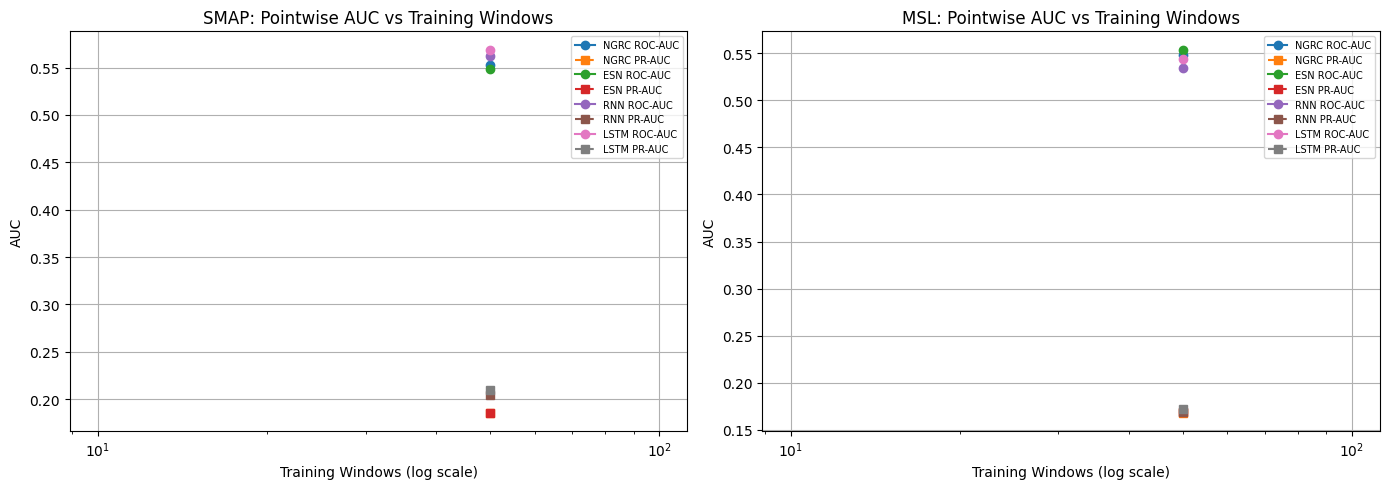

auc_plot.png saved


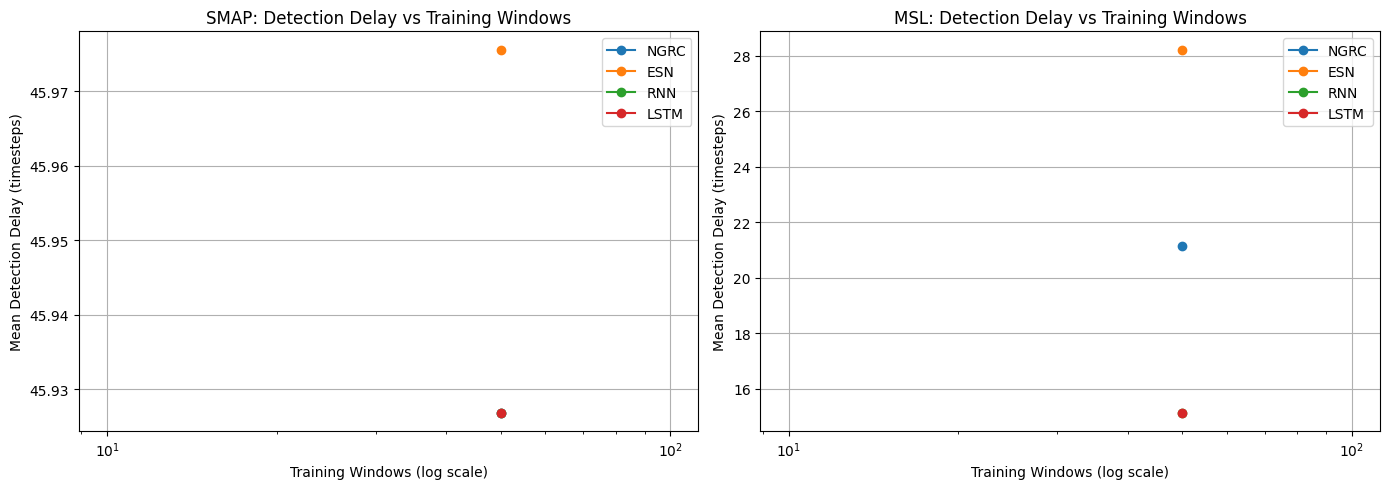

detection_delay_plot.png saved
  channel_importance_SMAP_NGRC_50win.csv saved
  channel_importance_SMAP_ESN_50win.csv saved
  channel_importance_SMAP_RNN_50win.csv saved
  channel_importance_SMAP_LSTM_50win.csv saved
  channel_importance_MSL_NGRC_50win.csv saved
  channel_importance_MSL_ESN_50win.csv saved
  channel_importance_MSL_RNN_50win.csv saved
  channel_importance_MSL_LSTM_50win.csv saved

=== 全出力完了 ===


In [44]:
# =============================================================================
# このセルの役割:
#   実験結果の出力。以下の成果物を生成する。
#   1. results.csv: 全実験結果テーブル (sensor_type, model, n_windows, roc_auc, pr_auc, delay)
#   2. auc_plot.png: SMAP/MSL 別 × モデル別の AUC 推移グラフ
#   3. detection_delay_plot.png: Detection Delay の推移グラフ
#   4. channel_importance_*.csv: チャネル番号 × 重要度のCSV (モデル/センサー/ウィンドウ数ごと)
# =============================================================================

# 1. results.csv
if all_results:
    final_df = pd.concat(all_results, ignore_index=True)
    final_df.to_csv("results.csv", index=False)
    print("results.csv saved")
    print(final_df.to_string())
else:
    print("結果がありません")
    final_df = pd.DataFrame()

# 2. AUC プロット
if not final_df.empty:
    sensor_types = final_df['sensor_type'].unique()
    fig, axes = plt.subplots(1, len(sensor_types), figsize=(7 * len(sensor_types), 5))
    if len(sensor_types) == 1:
        axes = [axes]
    for ax, sensor in zip(axes, sensor_types):
        sub = final_df[final_df['sensor_type'] == sensor]
        for model in ['NGRC', 'ESN', 'RNN', 'LSTM']:
            m_sub = sub[sub['model'] == model].sort_values('n_windows')
            if not m_sub.empty:
                ax.plot(m_sub['n_windows'], m_sub['roc_auc'], marker='o', label=f'{model} ROC-AUC')
                ax.plot(m_sub['n_windows'], m_sub['pr_auc'], marker='s', linestyle='--', label=f'{model} PR-AUC')
        ax.set_xscale('log')
        ax.set_xlabel('Training Windows (log scale)')
        ax.set_ylabel('AUC')
        ax.set_title(f'{sensor}: Pointwise AUC vs Training Windows')
        ax.legend(fontsize=7)
        ax.grid(True)
    plt.tight_layout()
    plt.savefig("auc_plot.png", dpi=150, bbox_inches='tight')
    plt.show()
    print("auc_plot.png saved")

# 3. Detection Delay プロット
if not final_df.empty:
    fig, axes = plt.subplots(1, len(sensor_types), figsize=(7 * len(sensor_types), 5))
    if len(sensor_types) == 1:
        axes = [axes]
    for ax, sensor in zip(axes, sensor_types):
        sub = final_df[final_df['sensor_type'] == sensor]
        for model in ['NGRC', 'ESN', 'RNN', 'LSTM']:
            m_sub = sub[sub['model'] == model].sort_values('n_windows')
            if not m_sub.empty:
                ax.plot(m_sub['n_windows'], m_sub['mean_detection_delay'], marker='o', label=model)
        ax.set_xscale('log')
        ax.set_xlabel('Training Windows (log scale)')
        ax.set_ylabel('Mean Detection Delay (timesteps)')
        ax.set_title(f'{sensor}: Detection Delay vs Training Windows')
        ax.legend()
        ax.grid(True)
    plt.tight_layout()
    plt.savefig("detection_delay_plot.png", dpi=150, bbox_inches='tight')
    plt.show()
    print("detection_delay_plot.png saved")

# 4. チャネル重要度 CSV
for sensor, ch_imp in all_channel_importance.items():
    for model_name, importance_dict in ch_imp.items():
        for n_win, imp_vec in importance_dict.items():
            fname = f"channel_importance_{sensor}_{model_name}_{n_win}win.csv"
            pd.DataFrame({'channel': range(len(imp_vec)), 'importance': imp_vec}).to_csv(fname, index=False)
            print(f"  {fname} saved")

print("\n=== 全出力完了 ===")